<a href="https://colab.research.google.com/github/JohnsonYu0924/114_2_text-analysis/blob/main/L11_Clustering_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering + Topic Modeling（非監督式學習）

## Dissents Data – Corpus Preprocessing

In [ ]:
mydir = "/content/"

from nltk.corpus.reader.plaintext import CategorizedPlaintextCorpusReader
documentPattern = r'[A-z0-9\s.]+\.txt'
categoryPattern = r'.*(pos|neg).*'

myCorpus1 = CategorizedPlaintextCorpusReader(
    mydir + "dissents/", documentPattern, cat_pattern=categoryPattern)


## Preprocessing Pipeline

In [ ]:
import os, re, string
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

wordnet = WordNetLemmatizer()
en_stop = set(stopwords.words('english'))

strCorpus = []
for file in myCorpus1.fileids():
    doc = myCorpus1.raw(file)
    doc = re.sub("\s+", " ", doc).lower()

    tokens = word_tokenize(doc)
    dissent = ""

    for word in tokens:
        if re.search("^[a-z]+$", word):
            if len(word) > 2 and word not in en_stop:
                word = wordnet.lemmatize(word)
                dissent += " " + word

    strCorpus.append(dissent)

strCorpus[1]


<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1307770036.py:16: SyntaxWarning: invalid escape sequence '\s'
  doc = re.sub("\s+", " ", doc).lower()
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


' author wodouglas type dissent justice douglas view petitioner substance tried murder twice violation guarantee double jeopardy dissent'

## Vectorization（One-hot, TF-IDF）

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Binarizer

freq = CountVectorizer()
corpus = freq.fit_transform(strCorpus)

onehot = Binarizer()
bool_text = onehot.fit_transform(corpus.toarray())


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(ngram_range=(1,1))
vec_text = tfv.fit_transform(strCorpus)

words = tfv.get_feature_names_out()

words[:10]

array(['ability', 'absolutely', 'accommodation', 'acted', 'aff', 'affirm',
       'allowing', 'already', 'also', 'always'], dtype=object)

## K-means Clustering（NLTK version）

In [ ]:
import nltk
from nltk.cluster import KMeansClusterer
my_k = 3
myDist = nltk.cluster.util.cosine_distance

model1 = KMeansClusterer(my_k, myDist, avoid_empty_clusters=True)
myClusters1 = model1.cluster(vec_text.toarray(), assign_clusters=True)
print(myClusters1)


[2, 0, 1, 1, 0, 0]


## K-means（scikit-learn version）

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, n_init=17, tol=0.01, max_iter=20)

myClusters2 = kmeans.fit(vec_text)
print(kmeans.predict(vec_text))

common_words = myClusters2.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))


[2 2 1 1 0 0]
0 : brennan, would, marshall, discrimination, richmond, though, great, justice, dissent, classification
1 : party, either, dissent, marshall, candidate, member, case, granting, argue, object
2 : property, douglas, dissent, wodouglas, destruction, jeopardy, twice, tried, violation, double


## Silhouette & Elbow

SilhouetteVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=3))

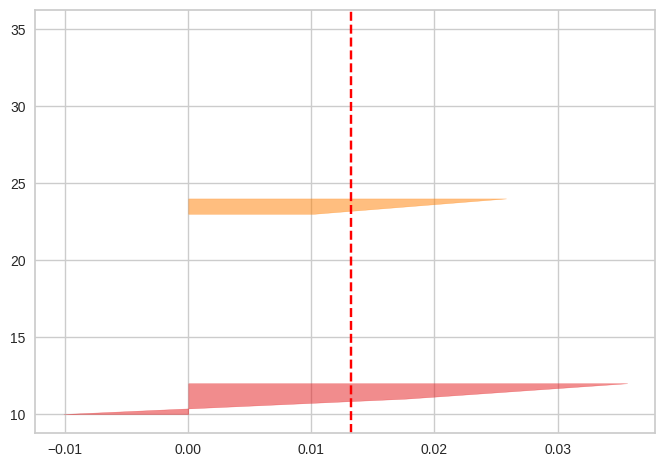

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

visualizer = SilhouetteVisualizer(KMeans(n_clusters=3))
visualizer.fit(vec_text.toarray())

# Silhouette Plot 橫軸 = silhouette score（介於 -1 到 1）
# 縱軸 = 每個 cluster 裡的資料點
# 每一個顏色＝一個群（cluster）

# 橘色區塊 = cluster 1
# 紅色區塊 = cluster 2
# 灰色區塊 = cluster 3
# 紅色虛線 = 所有樣本的平均 silhouette score

# 接近 1	分群效果很好：點離自己群很近、離其他群很遠
# 接近 0	邊界點：可能分到任一群都合理
# 小於 0	分錯群：離別群反而更近

# 三個 cluster 的 silhouette 幾乎都在 0 附近：
# 區塊全部接近 x=0 cluster 之間沒有明顯差異

/usr/local/lib/python3.12/dist-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.12/dist-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


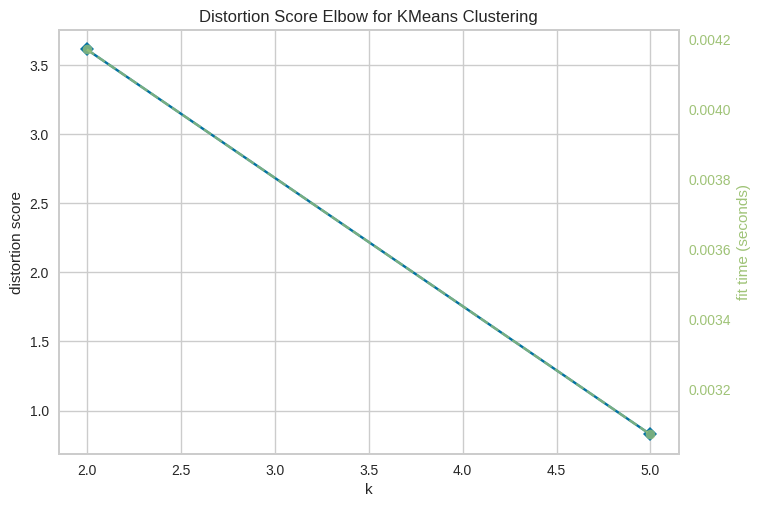

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
visualizer = KElbowVisualizer(KMeans(), metrics='silhouette', k=[2,5])
visualizer.fit(vec_text.toarray())
visualizer.poof()

#visualizer = KElbowVisualizer(
#    KMeans(random_state=42),
#    metric='distortion',
#    k=(2,5)
#)
# 若是希望 kmean 不變

# Elbow Plot: 找出最適合的聚類數 k。
## 藍色線：Distortion（又稱 inertia）
### 代表每個資料點到其所屬 cluster center 的距離總和。
### 值越小 → clustering 越小。
## 綠色虛線：fit time（模型運算時間）
### 不是用來判斷 k 的，是附加資訊（可忽略）。

# 這張圖顯示：
# k=2 → distortion = 3.6
# k=5 → distortion = 0.8
# 幾乎直線式地下降
# 資料沒有明顯的 elbow（也就是沒有明顯 cluster 結構）。

## Hierarchical Clustering（Agglomerative）

In [ ]:
from sklearn.cluster import AgglomerativeClustering
model4 = AgglomerativeClustering()
clusters4 = model4.fit(vec_text.toarray())

print(model4.labels_)

[1 1 0 0 0 0]


## Topic Modeling – LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda2 = LatentDirichletAllocation(n_components=3)
lda2.fit(vec_text)

for idx, topic in enumerate(lda2.components_):
    print("Topic", idx, " ".join(words[i] for i in topic.argsort()[:-11:-1]))  #因為 argsort() 是從小到大排序，而我們要找的是「權重最大的詞」。所以要從尾巴往前數。


Topic 0 guarantee dissent violation substance jeopardy double murder petitioner twice tried
Topic 1 dissent marshall either brennan dissentby violate protection equal ground fail
Topic 2 party property destruction candidate member may public war democratic republican


輸出成 csv

In [ ]:
import pandas as pd

n_top_words = 10
topic_results = []

for idx, topic in enumerate(lda2.components_):
    top_indices = topic.argsort()[:-n_top_words-1:-1]
    top_words = [words[i] for i in top_indices]

    topic_results.append({
        "topic": idx,
        "top_words": ", ".join(top_words)
    })

df_topics = pd.DataFrame(topic_results)
df_topics


,topic,top_words
0,0,"guarantee, dissent, violation, substance, jeop..."
1,1,"dissent, marshall, either, brennan, dissentby,..."
2,2,"party, property, destruction, candidate, membe..."


In [ ]:
df_topics.to_csv("lda_topics.csv", index=False)


輸出每個 topic 的前 10 個字與其權重

In [ ]:
topic_details = []

for topic_idx, topic in enumerate(lda2.components_):
    top_indices = topic.argsort()[:-n_top_words-1:-1]
    for i in top_indices:
        topic_details.append({
            "topic": topic_idx,
            "word": words[i],
            "weight": topic[i]
        })

df_topic_words = pd.DataFrame(topic_details)
df_topic_words.to_csv("lda_topic_weights.csv", index=False)
df_topic_words


,topic,word,weight
0,0,guarantee,0.639861
1,0,dissent,0.624590
2,0,violation,0.619637
3,0,substance,0.619637
4,0,jeopardy,0.619637
5,0,double,0.619637
6,0,murder,0.619637
7,0,petitioner,0.619637
8,0,twice,0.619637
9,0,tried,0.619637


每篇文件的主題分布

In [ ]:
doc_topic_matrix = lda2.transform(vec_text)
df_doc_topics = pd.DataFrame(doc_topic_matrix)
df_doc_topics.to_csv("lda_doc_topics.csv", index=False)
df_doc_topics


,0,1,2
0,0.043299,0.043303,0.913398
1,0.856022,0.072695,0.071283
2,0.063380,0.872297,0.064323
3,0.035028,0.035130,0.929842
4,0.065270,0.870401,0.064329
5,0.926395,0.037137,0.036469
